In [62]:
# example_meta_data_reader.ipynb
# Authors: Stephan Meighen-Berger
# Shows how to deal with the output files

In [63]:

import awkward as ak
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import h5py
import json
%matplotlib widget
# %matplotlib qt

In [64]:
# Example loading a directory (highly recommend using lazy loading)
example_set = ak.from_parquet('./output/1_photons.parquet')

In [65]:
meta = pq.read_metadata('./output/1_photons.parquet').metadata[b'config_prometheus']
jmeta = json.loads(meta)
jmeta['general']

{'version': 'github'}

In [66]:
pq.read_metadata('./output/1_photons.parquet')

  created_by: parquet-cpp-arrow version 8.0.0
  num_columns: 26
  num_rows: 10
  num_row_groups: 1
  format_version: 1.0
  serialized_size: 29006

In [67]:
# Example loading a single file
# example_set = ak.from_parquet('./output/custom_1337_meta_data.parquet')

In [68]:
# The events are split into three parts:
#   - lepton: the light from the generated lepton
#   - hadron: the light produced from the associated hadronic cascade (at production point)
#   - total: the light from both parts
# Each of these fields is formatted the same way
example_set.fields

['mc_truth', 'photons']

In [69]:
# Example for one event
event_id = 0
# The sensors hit
print("Total number of hits:")
print(len(example_set.photons.sensor_id[event_id]))
print('The hit sensors: ')
print(example_set.photons.sensor_id[event_id])
print('Their associated strings')
print(example_set.photons.string_id[event_id])
print('The hit times')
print(example_set.photons.t[event_id])

Total number of hits:
1876
The hit sensors: 
[17, 16, 17, 17, 17, 15, 15, 15, 15, ..., 16, 16, 16, 17, 17, 17, 17, 17, 17]
Their associated strings
[39, 46, 46, 46, 46, 60, 60, 60, ..., 101, 101, 101, 101, 101, 101, 101, 101]
The hit times
[2.44e+03, 1.92e+03, 1.65e+03, 1.89e+03, ..., 938, 1.28e+03, 1.07e+03, 1.26e+03]


In [77]:
example_set.photons.sensor_pos_x

<Array [[-123, -76.1, -76.1, ..., 332, 332], ..., []] type='10 * var * float64'>

In [85]:
def parquet_sub_plotting(
        data, e_id, det,
        channel='photons',
        scaling=20,
        number_of_hits=1000,
        hitcut=3,
        offset=0
    ):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    hit_counts = []
    print(len(data[channel].sensor_pos_x[e_id])-1)
    subset_ids = np.random.randint(
        0,
        len(data[channel].sensor_pos_x[e_id])-1,
        size=number_of_hits
    )
    print('Total amount of hits: %d' %len(data[channel].sensor_pos_x[e_id]))
    print('Using a subset of %d for plotting' %number_of_hits)
    event_id = e_id
    sensor_comb = np.array([
        [data[channel].sensor_pos_x[event_id][subset_ids][i],
        data[channel].sensor_pos_y[event_id][subset_ids][i],
        data[channel].sensor_pos_z[event_id][subset_ids][i]
        ]
        for i in range(number_of_hits)
    ])
    print('Fetching unique modules and their hits')
    hit_doms, hit_counts = np.unique(sensor_comb, axis=0, return_counts=True)
    print('Number of hit doms: %d' %len(hit_doms))
    hit_counts = np.log10(hit_counts)
    hit_counts[hit_counts < np.log10(hitcut)] = 0.
    print('Finished the modules')
    print('Plotting...')
    ax.scatter(
        hit_doms[:, 0],
        hit_doms[:, 1],
        hit_doms[:, 2]+offset,
        s=(
            hit_counts * scaling
        ),
        color='r', alpha=0.5)
    print('Finished modules')
    ax.scatter(
        det[:, 0],
        det[:, 1],
        det[:, 2]+offset,
        s=1,
        color='k', alpha=0.5)
    # ax.set_xlim(min(det[:, 0]), max(det[:, 0]))
    # ax.set_ylim(min(det[:, 1]), max(det[:, 1]))
    # ax.set_zlim(min(det[:, 2]), max(det[:, 2]))
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    plt.title(
        'Event %d with pdg id = %d and energy %.1f GeV' % (
            event_id,
            data.mc_truth.final_state_type[event_id][0],
            data.mc_truth.final_state_energy[event_id][0]
            )
    )
    plt.show()

In [86]:
# Getting the detector
pos = []
with open('../resources/geofiles/arca.geo') as geo_in:
    read_lines = geo_in.readlines()
    modules_i = read_lines.index("### Modules ###\n")   
    for line in read_lines[modules_i+1:]:
        line = line.strip("\n").split("\t")
        pos.append(
            np.array([float(line[0]), float(line[1]),
            float(line[2])]))
    det = np.array(pos)
det = det#  - np.mean(det, axis=0)

1875
Total amount of hits: 1876
Using a subset of 1000 for plotting
Fetching unique modules and their hits
Number of hit doms: 53
Finished the modules
Plotting...
Finished modules


/tmp/ipykernel_1098/127794781.py:32: RuntimeWarning: divide by zero encountered in log10
  hit_counts[hit_counts < np.log10(hitcut)] = 0.


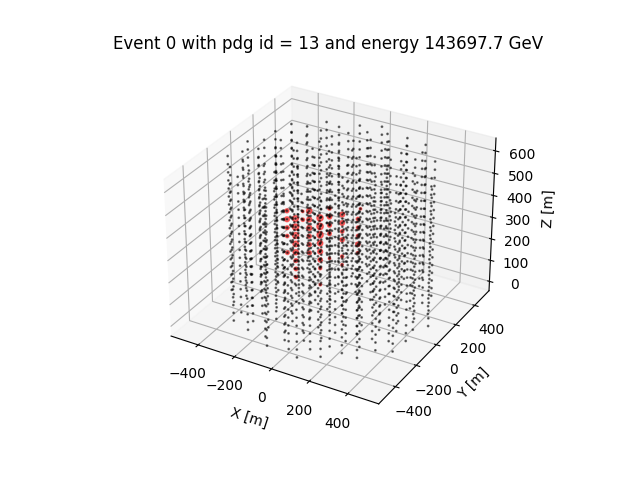

In [88]:
parquet_sub_plotting(
    example_set,
    e_id=0, det=det,
    channel='photons',
    scaling=10,
    number_of_hits=1000,
    hitcut=0,
    offset=3500
)

In [ ]:
def radius(k,n,b):
    if k > (n-b):
        r = 1
    else:
        r = np.sqrt(k-1/2) / np.sqrt(n-(b+1)/2)
    return r

def sunflower(n, alpha):
    b = int(alpha * np.sqrt(n))
    phi = (np.sqrt(5) + 1) / 2
    coords = []
    for k in range(1, n):
        r = radius(k, n, b)
        theta = 2 * np.pi * k / phi**2
        coord = np.array([r * np.cos(theta), r * np.sin(theta)])
        coords.append(coord)
    return np.array(coords)

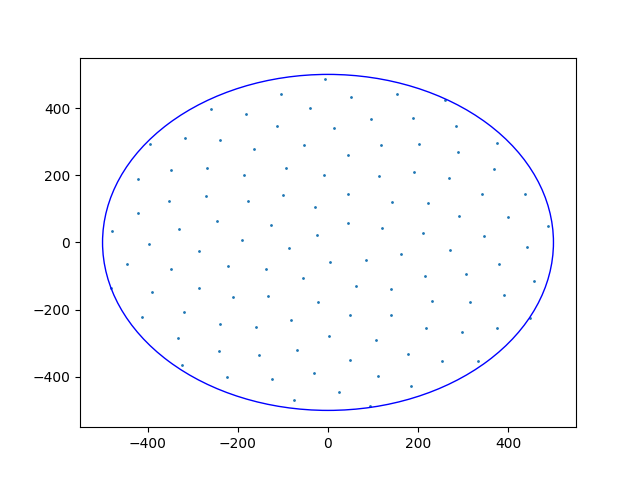

In [ ]:
ax = plt.gca()
ax.cla() # clear things for fresh plot
coords = sunflower(116, 0.3) * 500.
ax.scatter(coords[:, 0], coords[:, 1], s=1)
circle2 = plt.Circle((0, 0), 500, color='b', fill=False)
ax.add_patch(circle2)
plt.show()

In [ ]:
full_coords = []
spacing = 36.
modules = 18
depth = 3500
for string in coords:
    for i in range(modules):
        full_coords.append(np.append(string, -depth + ((modules - 1) -i) * spacing))
full_coords = np.array(full_coords)

In [ ]:
import sys
sys.path.append('../')

In [ ]:
from prometheus.utils.geo_utils import geo_from_coords

In [ ]:
geo_from_coords(full_coords, 'arca.geo', medium='water')

In [ ]:
18 * 115

2070